In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (36, 829, 517)


(44, (829, 517, 44))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42
n_lookforward=1

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
#a=np.round(np.expm1(rawy[~np.isnan(rawy)]))

In [12]:
ondate_cols=[ u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364',u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday',
            'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0']
#ondate_cols=[ u'PRCP']
#ondate_cols=columns
ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
ondate_train_test=normalize(ondate_train_test)
ondate_train_test.shape

(15,) 0.0676982591876 123.878437859


(829, 517, 15)

In [13]:
lag_cols=columns

lag_cols=array([u'visitors', u'geo1_visitors_mean', u'geo2_visitors_mean',
       u'station_visitors_mean', u'genre_name_visitors_mean',
       u'day_of_week_visitors_mean', u'visitor_lag7', u'visitor_lag14',
       u'visitor_lag28', u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364', u'visitor_ma2', u'visitor_ma4', u'visitor_ma7',
       u'visitor_ma14', u'visitor_ma28', u'visitor_ma56', u'visitor_ma112',
       u'visitor_ma224', u'visitor_sma1', u'visitor_sma2', u'visitor_sma3',
       u'visitor_sma4', u'visitor_sma8', u'visitor_sma16',
       u'visitor_sma32'] +['count_y1','geo1_count_y1','station_count_y1','geo2_count_y1'] )
#lag_cols=['holiday']
lag_train_test=data[:,:,get_index(lag_cols)].copy()
lag_train_test=normalize(lag_train_test)
lag_train_test.shape

(31,) 0.168403891412 3.02795093092


(829, 517, 31)

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [15]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [16]:
print K.floatx()

float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*7, batchsize=128,valid_split=0.1,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
valid_gen=None
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*7,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

rand split across time
train has 319288 records out of 354812 records
valid has 35524 records out of 354812 records
train has 5803 records out of 5803 records
no valid set


In [19]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2494
0


In [20]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [21]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(31, 15, (1, 15))

In [22]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [23]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [25]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test2", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200, use_output_exp=True,
                  params=parameter)
a._make_model()
a.params

(?, 42, 62)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [26]:
#a.model.summary()
a.model.count_params()

467203

In [27]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2494/2494 [==============================] - 74s 30ms/step - loss: 0.3413 - total_loss: 0.3413 - reg_loss: 0.3413 - val_loss: 0.2715 - val_total_loss: 0.2715 - val_reg_loss: 0.2715
Epoch 2/200
2494/2494 [==============================] - 72s 29ms/step - loss: 0.2923 - total_loss: 0.2923 - reg_loss: 0.2923 - val_loss: 0.2681 - val_total_loss: 0.2681 - val_reg_loss: 0.2681
Epoch 3/200
2494/2494 [==============================] - 72s 29ms/step - loss: 0.2830 - total_loss: 0.2830 - reg_loss: 0.2830 - val_loss: 0.2671 - val_total_loss: 0.2671 - val_reg_loss: 0.2671
Epoch 4/200
2494/2494 [==============================] - 72s 29ms/step - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756 - val_loss: 0.2493 - val_total_loss: 0.2493 - val_reg_loss: 0.2493
Epoch 5/200
2494/2494 [==============================] - 72s 29ms/step - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695 - val_loss: 0.2489 - val_total_loss: 0.2489 - val_reg_loss: 0.2489
Epoch 6/200
2494/2494 [============

<rrvf_model.KerasModel instance at 0x7f11d0138fc8>

In [28]:
a.traingen=train_gen

In [29]:
a.eval_valid()

best_epochs [6, 8, 9, 5, 4]
0.241813728548 0.241813728548
(1, 0.24181372854833022)


In [30]:
yy_pred=a.predict(300)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [6, 8, 9, 5, 4]
(829, 1) 2.63910679111 (829,)
0.233670108321 0.233670108321
(1, 0.23367010832143015)


In [31]:
traindata=train_gen.get_train()

In [32]:
def predict_train(self):
    X, y, mask,w = self.traingen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [33]:
def predict_test(self):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [34]:
gc.collect()

577

In [35]:
result=predict_train(a)

best_epochs [6, 8, 9, 5, 4]
(319288, 1) 2.70160251083 (319288, 2)


In [36]:
result[4].keys()

['masky', 'ondatex', 'lagx']

In [37]:
result[4]['lagx'].shape

(319288, 42, 31)

In [38]:
df=pd.DataFrame({'y':result[2][:,0]})

In [39]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [40]:
df=df.loc[df['y']>0]

In [41]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [42]:
import rrvf_data

In [43]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [44]:
import seaborn as sns; sns.set(color_codes=True)

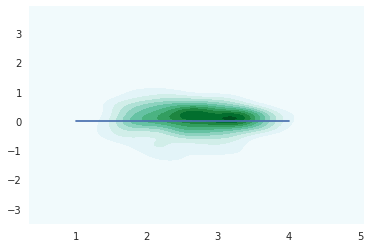

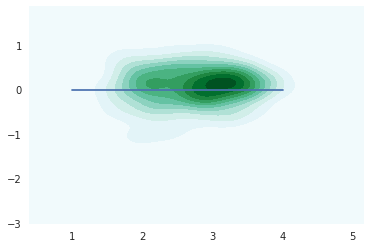

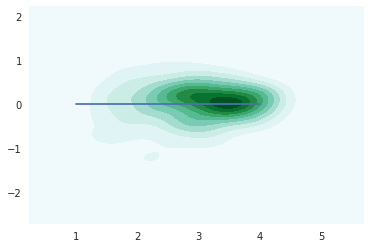

In [70]:
if 1:
    for i in range(1,8):
        plt.plot(np.arange(1,5),np.arange(1,5)*0)
        sns.kdeplot(df['pred'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
        plt.show()

In [46]:
rrvf_data.idx_to_date([406,407])

array(['2017-02-10', '2017-02-11'],
      dtype='|S10')

In [69]:
if 0:
    df['tmp']=np.round(df['y']*2.0)/2
    for i in range(1,8):
        print i
        if 1:
            s=df[['tmp','error2']][df['day']==i].groupby('tmp').count().iloc[:,0]
            s=s/float(df.shape[0])
            plt.bar(s.index,s.values)
        plt.show()

In [1]:
if 0:
    for i in range(1,8):
        plt.plot(np.arange(1,5),np.arange(1,5))
        sns.kdeplot(df['y'][df['day']==i].values,df['pred'][df['day']==i].values, shade=True)
        plt.show()

NameError: name 'plt' is not defined

In [49]:
gc.collect()

21

In [50]:
df2=df.groupby("dayidx").mean() 

In [51]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [52]:
df2[['day','error2']].groupby('day').median()

error2
day          
1    0.279890
2    0.254053
3    0.241029
4    0.256209
5    0.200620
6    0.205943
7    0.278835

In [53]:
rrvf_data.idx_to_date([477])

array(['2017-04-22'],
      dtype='|S10')

In [54]:
if 0:
    for i in range(1,8):
        print i
        df2[df2['day']==i]['error2'].plot();
        plt.ylim([0.15,0.5])
        plt.show()

In [55]:
df2.sort_values('error2').tail(20)

y      pred     error    error2  day        date
dayidx                                                         
136     2.545961  2.571601 -0.025640  0.323925    1  2016-05-16
445     2.576431  2.644864 -0.068433  0.324758    2  2017-03-21
331     2.779588  2.827727 -0.048139  0.325124    7  2016-11-27
121     2.992879  2.923178  0.069701  0.326160    7  2016-05-01
79      3.105372  3.084494  0.020878  0.329809    7  2016-03-20
185     2.582898  2.620175 -0.037277  0.336055    1  2016-07-04
191     2.868818  2.901476 -0.032658  0.337392    7  2016-07-10
82      2.771992  2.849074 -0.077081  0.339149    3  2016-03-23
73      2.609337  2.600552  0.008786  0.346312    1  2016-03-14
263     2.374733  2.541529 -0.166796  0.359208    2  2016-09-20
122     2.917898  2.684183  0.233715  0.360067    1  2016-05-02
52      2.578535  2.580569 -0.002034  0.362370    1  2016-02-22
115     2.613981  2.648633 -0.034652  0.369183    1  2016-04-25
364     3.026092  3.022432  0.003660  0.376790    5  2016-12-30
184     2.857677  2.869755 -0.012078  0.386951    7  2016-07-03
182     2.979749  2.941293  0.038455  0.392584    5  2016-07-01
183     3.031673  3.049892 -0.018219  0.394778    6  2016-07-02
234     2.340747  2.482343 -0.141596  0.416548    1  2016-08-22
366     2.680166  2.693978 -0.013812  0.430479    7  2017-01-01
365     2.693053  2.783959 -0.090907  0.452256    6  2016-12-31

In [56]:
holiday=pd.read_csv('../input/date_info.csv')
holiday=holiday[holiday['holiday_flg']==1]

In [57]:
import rrvf_data

In [58]:
result=predict_test(a)

best_epochs [6, 8, 9, 5, 4]
(5803, 1) 2.72467169369 (5803, 2)


In [59]:
df=pd.DataFrame({'y':result[2][:,0]})

In [60]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [61]:
df=df.loc[df['y']>0]

In [62]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [63]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [64]:
df2=df.groupby("dayidx").mean() 

In [65]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [66]:
df2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930330 -0.001220  0.266650    7  2017-04-16
472     2.507290  2.578893 -0.071603  0.249687    1  2017-04-17
473     2.661330  2.638613  0.022716  0.274129    2  2017-04-18
474     2.754815  2.713805  0.041010  0.232518    3  2017-04-19
475     2.713762  2.693885  0.019876  0.262512    4  2017-04-20
476     2.999000  2.928404  0.070595  0.172670    5  2017-04-21
477     3.075529  3.088795 -0.013266  0.202569    6  2017-04-22

In [67]:
472%7

3